In [48]:
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

In [49]:
tf.set_random_seed(41)
np.random.seed(21)

batch_size = 100
learning_rate = 0.001              # learning rate
num_steps = 1000
display_step = 100

Extracting ./mnist\train-images-idx3-ubyte.gz
Extracting ./mnist\train-labels-idx1-ubyte.gz
Extracting ./mnist\t10k-images-idx3-ubyte.gz
Extracting ./mnist\t10k-labels-idx1-ubyte.gz
The shape of training data is:  (55000, 784)
The shape of training label is: (55000, 10)
The shape of test data is:  (10000, 784)
The shape of test label is: (10000, 10)
The shape of validation data is:  (5000, 784)
The shape of validation label is: (5000, 10)


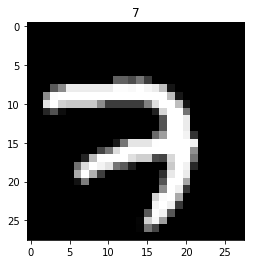

In [50]:
# Import MNIST data
mnist = input_data.read_data_sets('./mnist', one_hot=True)  # they has been normalized to range (0,1)

# plot one example
print('The shape of training data is: ', mnist.train.images.shape)     # (55000, 28 * 28)
print('The shape of training label is:', mnist.train.labels.shape)   # (55000, 10)
print('The shape of test data is: ', mnist.test.images.shape)     # (10000, 28 * 28)
print('The shape of test label is:', mnist.test.labels.shape)   # (10000, 10)
print('The shape of validation data is: ', mnist.validation.images.shape)     # (5000, 28 * 28)
print('The shape of validation label is:', mnist.validation.labels.shape)   # (5000, 10)

plt.imshow(mnist.train.images[0].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(mnist.train.labels[0]))
plt.show()

In [51]:
test_x = mnist.test.images[:2000]
test_y = mnist.test.labels[:2000]

![alt cnn](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/2934e9a15d0619d04ae4a4d4e2951e2ff4f45d93/21-FigureD.2-1.png)

In [52]:
tf_x = tf.placeholder(tf.float32, [None, 28*28]) / 255.
tf_y = tf.placeholder(tf.int32, [None, 10])

image = tf.reshape(tf_x, [-1, 28, 28, 1])              # (batch, height, width, channel)

# CNN
conv1 = tf.layers.conv2d(
    inputs=image,
    filters=32,
    kernel_size=[5, 5],
    padding='same',
    activation=tf.nn.relu)           # -> (28, 28, 32)

pool1 = tf.layers.max_pooling2d(
    inputs=conv1,
    pool_size=[2, 2],
    strides=2)           # -> (14, 14, 32)

conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[5, 5], 
    padding='same', 
    activation=tf.nn.relu)    # -> (14, 14, 64)

pool2 = tf.layers.max_pooling2d(
    inputs=conv2,
    pool_size=[2, 2],
    strides=2)    # -> (7, 7, 64)

flat = tf.reshape(pool2, [-1, 7*7*64])          # -> (7*7*64, )
output = tf.layers.dense(flat, 10)              # output layer

In [53]:
# https://www.tensorflow.org/api_docs/python/tf/losses/softmax_cross_entropy
loss_op = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)           # compute cost
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
prediction = tf.nn.softmax(output)
#correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(tf_y, 1))
#accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# https://www.tensorflow.org/api_docs/python/tf/metrics/accuracy
accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1),)[1]


In [54]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm

try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('\nPlease install sklearn for layer visualization\n')

def plot_with_labels(lowDWeights, labels):
    plt.cla(); X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

Step: 0 | train loss: 2.3063 | test accuracy: 0.16


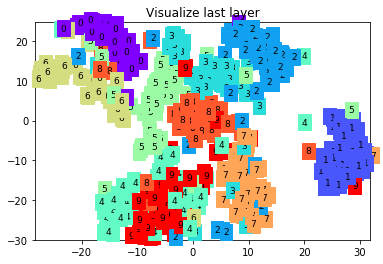

Step: 100 | train loss: 0.1999 | test accuracy: 0.54


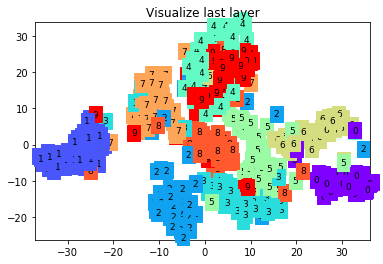

Step: 200 | train loss: 0.1417 | test accuracy: 0.68


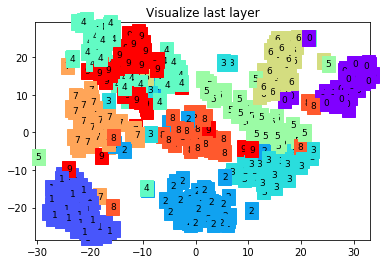

Step: 300 | train loss: 0.1089 | test accuracy: 0.75


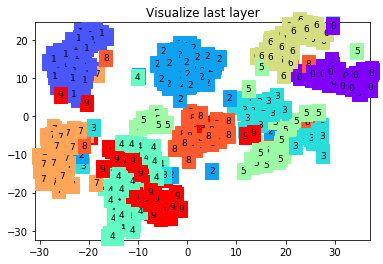

Step: 400 | train loss: 0.1484 | test accuracy: 0.80


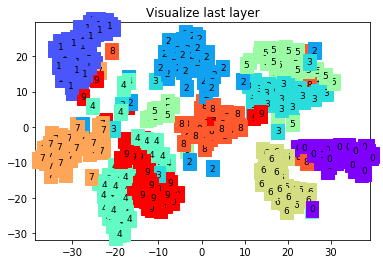

Step: 500 | train loss: 0.0484 | test accuracy: 0.83


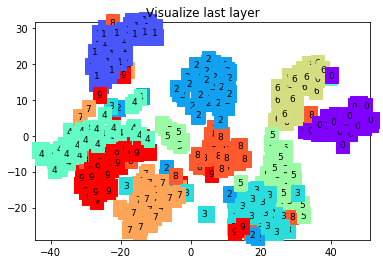

Step: 600 | train loss: 0.0354 | test accuracy: 0.85


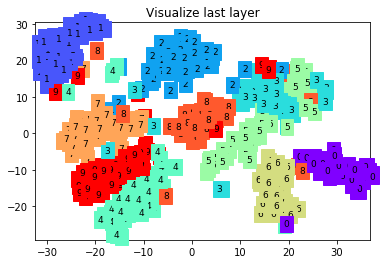

Step: 700 | train loss: 0.0231 | test accuracy: 0.86


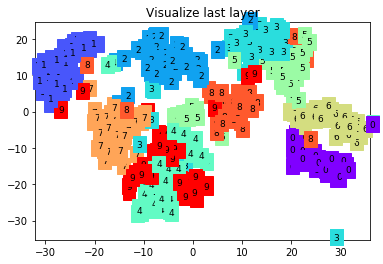

Step: 800 | train loss: 0.0806 | test accuracy: 0.88


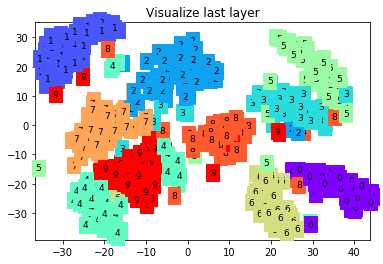

Step: 900 | train loss: 0.0437 | test accuracy: 0.89


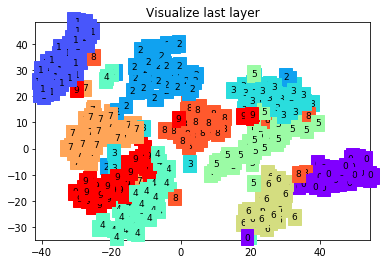

In [55]:
#sess = tf.Session()
# https://www.tensorflow.org/api_docs/python/tf/group
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op

# Start training
with tf.Session() as sess:
    sess.run(init_op)     # initialize var in graph

    plt.ion()
    
    for step in range(num_steps):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        _, loss_ = sess.run([train_op, loss_op], {tf_x: batch_x, tf_y: batch_y})
        if step % display_step == 0:
            accuracy_, flat_representation = sess.run([accuracy, flat], {tf_x: test_x, tf_y: test_y})
            print('Step:', step, '| train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000); plot_only = 500
                low_dim_embs = tsne.fit_transform(flat_representation[:plot_only, :])
                labels = np.argmax(test_y, axis=1)[:plot_only]; plot_with_labels(low_dim_embs, labels)
    plt.ioff()

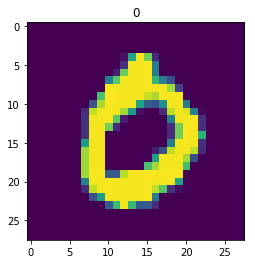

Answer: [1]
prediction: [[0.10155666 0.11333745 0.09804887 0.1015676  0.0948794  0.09935666
  0.11082147 0.08589536 0.10214458 0.09239194]]


In [60]:
# Evaluate model
# argmax returns the index with the largest value across axes of a tensor
ans = tf.argmax(prediction, 1)

# Show image that we want to predict
plt.imshow(mnist.test.images[3].reshape((28, 28)))
plt.title('%i' % np.argmax(mnist.test.labels[3]))
plt.show()

# Running a test dataset by loading the model saved earlier
with tf.Session() as sess:
    # Run the initializer
    sess.run(init_op)
 
    # Calculate the answer for the image
    print("Answer:", sess.run(ans, feed_dict={tf_x: mnist.test.images[3:4]}))
    print("prediction:", sess.run(prediction, feed_dict={tf_x: mnist.test.images[3:4]}))

# print 10 predictions from test data
#with tf.Session() as sess:
#    test_output = sess.run(output, {tf_x: test_x[:10]})
#    pred_y = np.argmax(test_output, 1)
#    print(pred_y, 'prediction number')
#    print(np.argmax(test_y[:10], 1), 'real number')